ДЗ 2 Взять ряд из первого задания (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения в почему была выбрана та или иная модель. (задание оформить в jupyter-notebook)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import autocorrelation_plot
from scipy.stats import boxcox
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv("monthly-us-auto-registration-tho.csv", sep=';')
df2 = pd.read_csv("weekly-closings-of-the-dowjones-.csv", sep = ',')

In [4]:
df.columns = ['Month', 'Count']
df2.columns = ['Week', 'Count']

#### Делаем ряды стационарными

In [5]:
modified = boxcox(df['Count'], 0)
modified2 = boxcox(df2['Count'], 0)
modified = np.diff(modified, 2)
modified2 = np.diff(modified2, 2)

In [6]:
################
 # Dickey-Fuller
##################
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [7]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [8]:
test_stationarity(df['Count'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.225039
p-value                          0.662733
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


In [9]:
test_stationarity(modified)

Results of Dickey-Fuller Test:
Test Statistic                -1.075967e+01
p-value                        2.539779e-19
#Lags Used                     1.200000e+01
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


In [10]:
test_stationarity(modified2)

Results of Dickey-Fuller Test:
Test Statistic                  -5.099378
p-value                          0.000014
#Lags Used                      14.000000
Number of Observations Used    145.000000
Critical Value (1%)             -3.476273
Critical Value (5%)             -2.881688
Critical Value (10%)            -2.577513
dtype: float64


/home/pavel/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


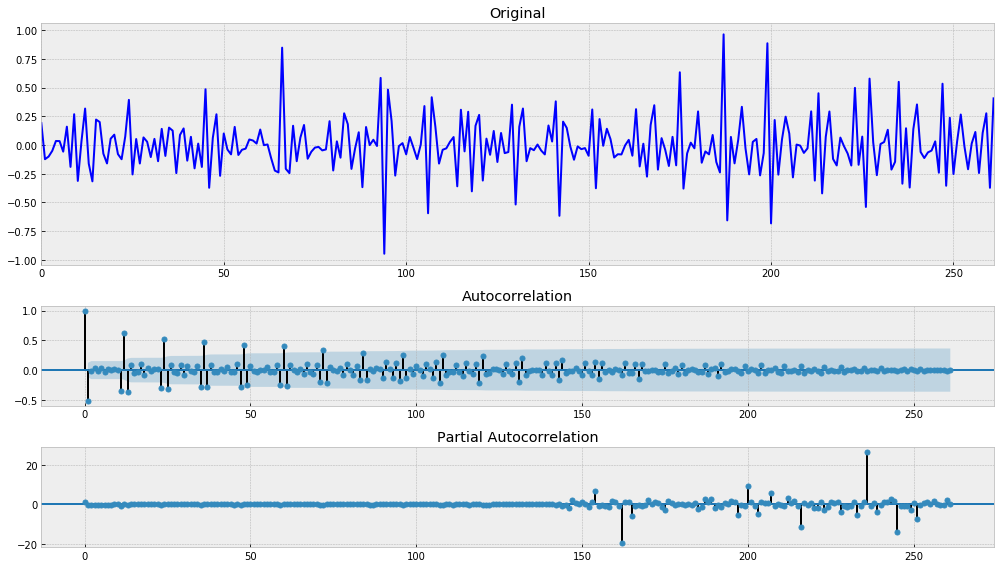

In [11]:
tsplot(modified)

/home/pavel/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


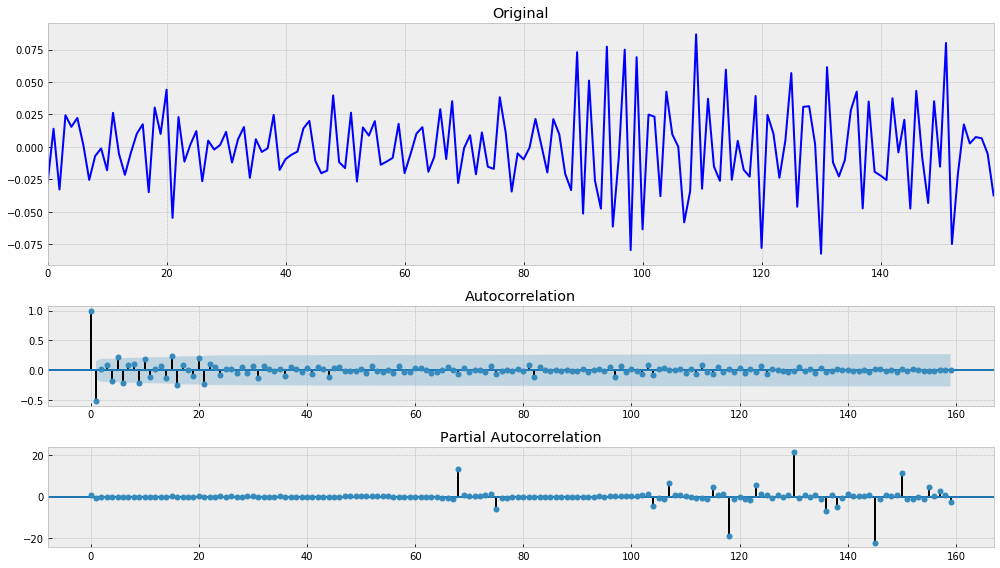

In [12]:
tsplot(modified2)

In [13]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [14]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [15]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [16]:
ema = exponential_moving_average(modified, 0.2)
wma = weighted_moving_average(modified, 7, [1,1,2,3,5,8,13])
ma = moving_average(modified, 7)

In [17]:
ema_orig = exponential_moving_average(df['Count'], 0.2)
wma_orig = weighted_moving_average(df['Count'], 7, [1,1,2,3,5,8,13])
ma_orig = moving_average(df['Count'], 7)

#### Отразим на одном графике все известные простые модели экспоненциального сглаживания 

###### оригинальный ряд

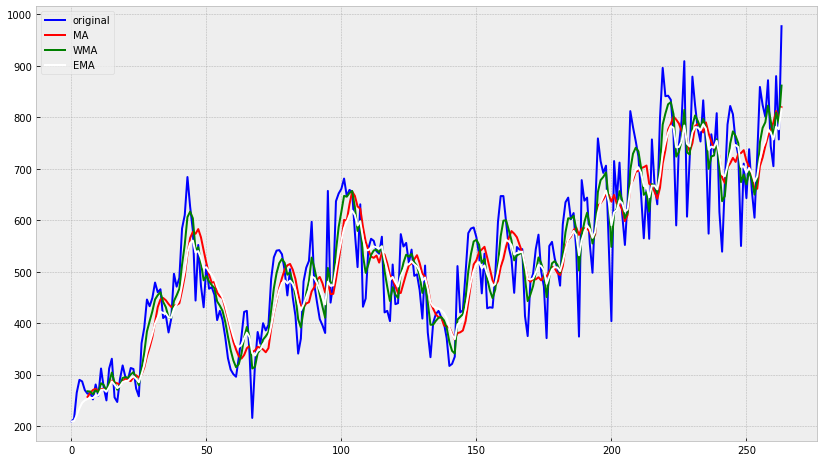

In [18]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(df['Count'], color='blue',label='original')
    plt.plot(ma_orig, color='red', linewidth='2', label='MA')
    plt.plot(wma_orig, color='green', linewidth='2', label='WMA')
    plt.plot(ema_orig, color='white', linewidth='2', label='EMA')
    plt.legend()

#### стационарный ряд

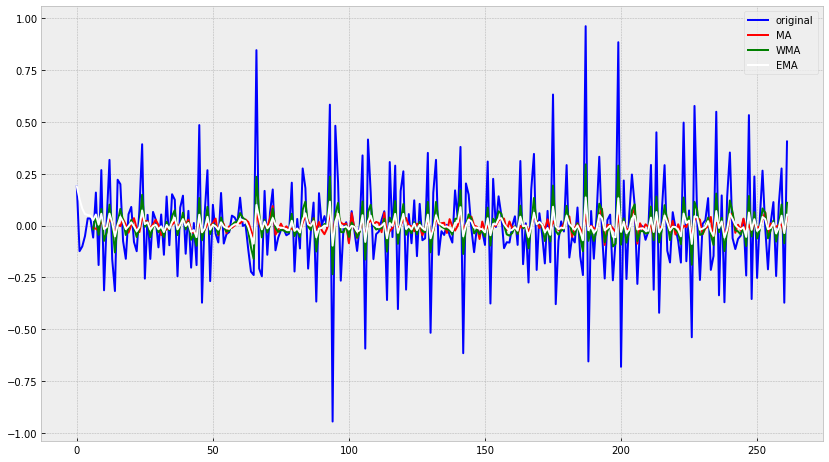

In [19]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(modified, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='white', linewidth='2', label='EMA')
    plt.legend()

#### Пробуем двойное экспоненциальное сглаживание

In [20]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [21]:
def plot_dema(alpha, beta, orig):
    dema = double_ema(orig, 0.2, 0.2)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(orig, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='2', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

#### Оригинальный ряд 

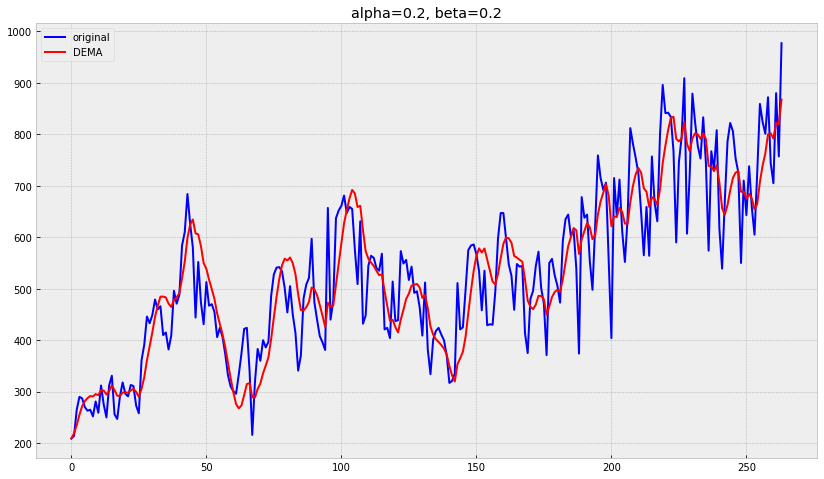

In [22]:
plot_dema(0.2, 0.2, df['Count'])

#### Стационарный ряд 

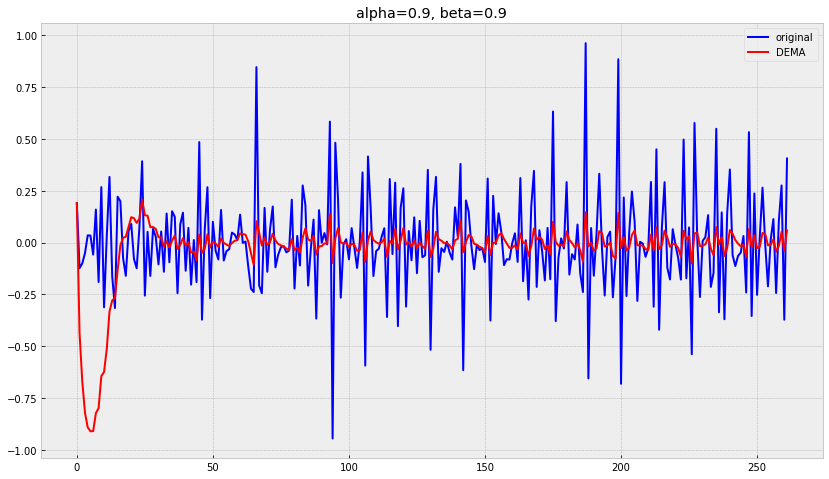

In [23]:
plot_dema(0.9, 0.9, modified)

#### Тройное экспоненциальное сглаживание Хольт-Винтерс 

In [24]:
i = 0
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [25]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [26]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [27]:
tema = triple_exponential_smoothing(df["Count"], 12, 0.1, 0.1, 0.2, 24)

In [28]:
def plot_tema(alpha, beta, gamma, ser, ser_to_plot, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='2', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

In [29]:
## Оригинальный ряд

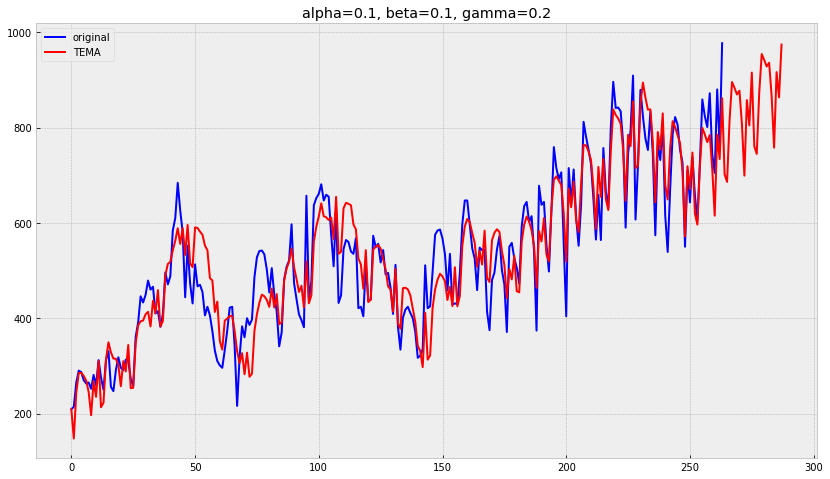

In [30]:
plot_tema(0.1, 0.1, 0.2, df['Count'], df['Count'])

In [31]:
## Стационарный ряд

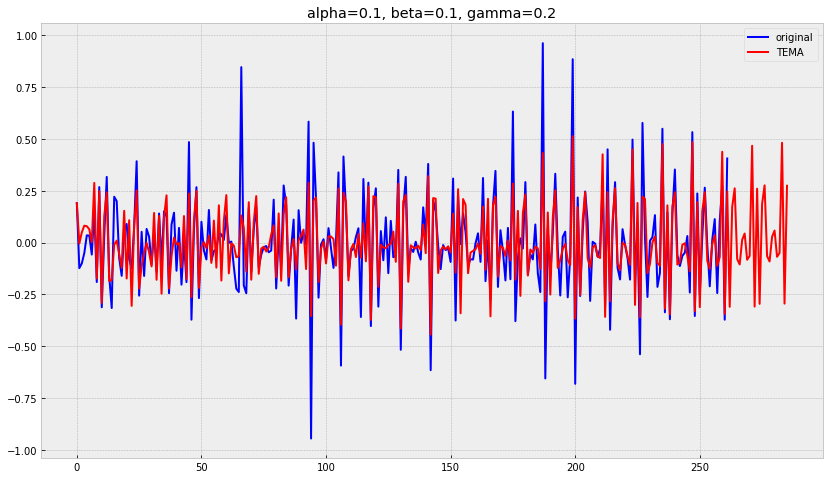

In [32]:
plot_tema(0.1, 0.1, 0.2, modified, modified)

In [33]:
series = df["Count"]

In [34]:
train, test, val = series[:60], series[60:70], series[70:]

In [35]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [36]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [37]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 4522.293902164624
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.09494702e-05,  8.93446941e+03,  2.72848411e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 112
      nit: 18
   status: 0
  success: True
        x: array([0.55821637, 0.        , 0.65704939])


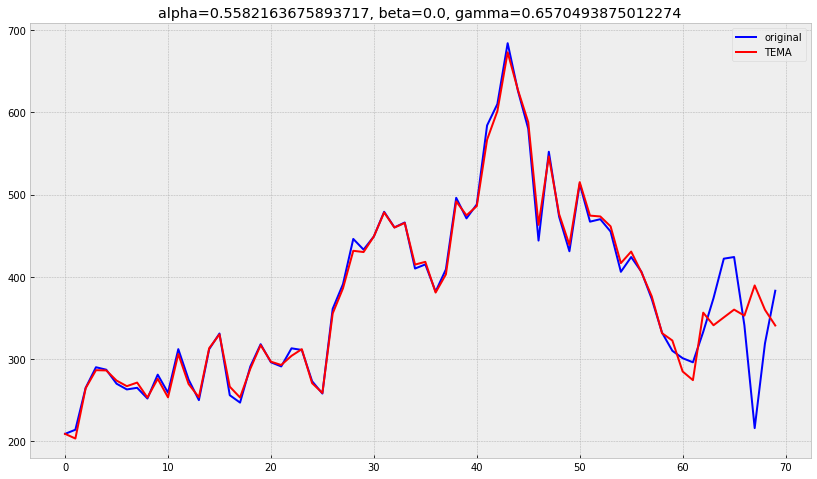

In [38]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:70], n_preds=len(test))

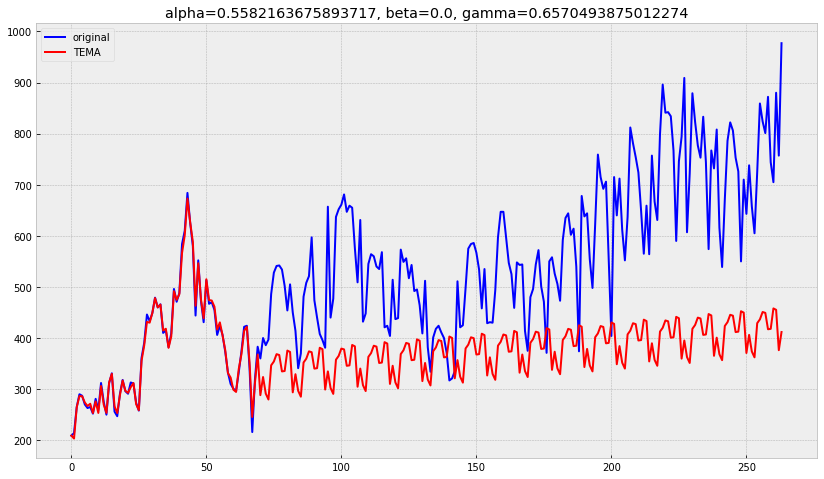

In [39]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:70], ser_to_plot=series, n_preds=len(val))

In [68]:
series = df['Count']
train, val = modified[:65], modified[65:]

In [77]:
from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=4) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

In [78]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [79]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 4.03840150293104
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.08562073e-06,  3.46389584e-06, -4.02349620e-01])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 104
      nit: 23
   status: 0
  success: True
        x: array([0.50730875, 0.09782799, 1.        ])


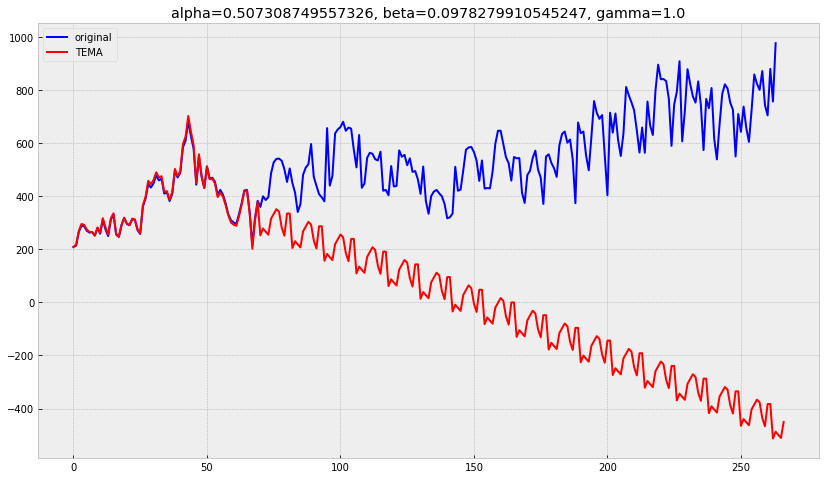

In [80]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:70], ser_to_plot=series, n_preds=len(val))

In [63]:
series = modified
train, val = modified[:65], modified[65:]

In [64]:
from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=5) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

In [65]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [66]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.30472049700421455
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 7.98250355e-06,  3.46944695e-06, -3.72479825e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 124
      nit: 25
   status: 0
  success: True
        x: array([0.08129488, 0.40654067, 0.97052619])


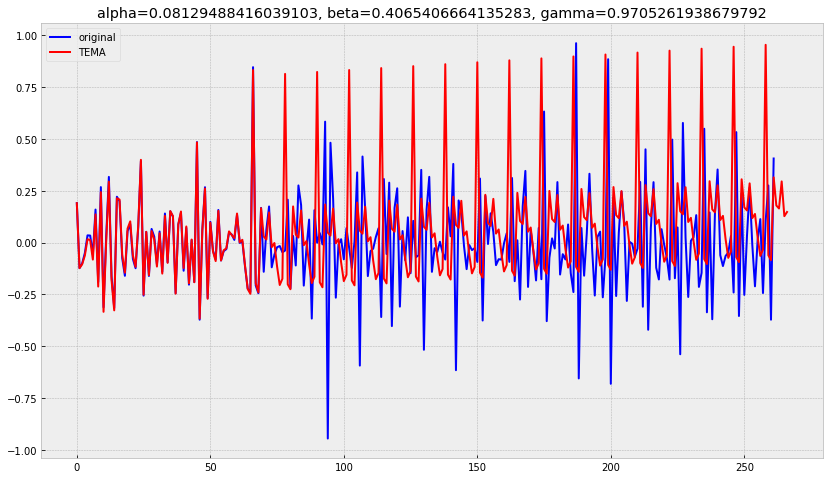

In [67]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:70], ser_to_plot=series, n_preds=len(val))

In [81]:
### Лучше всего работает модель Хольт-Винтерса с кросс-валидацией и оптимизацией параметров